# Разработка стратегии взаимодействия с клиентами фитнес-центра на основе аналитических данных

### Описание данных

Нам доступны данные с информацией о клиентах и журнале их посещений на месяц до оттока и факт оттока на определённый месяц.

### План
1. Открыть и изучить файл с данными
1. Предобработать данные для анализа
1. Провести исследовательский анализ данных
1. Построить модель прогнозирования оттока
1. Сделать кластеризацию клиентов
1. Написать общий вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from IPython.display import display
warnings.filterwarnings('ignore')

### Шаг 1. Знакомство с данными

In [2]:
df = pd.read_csv('gym_churn.csv')

In [3]:
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3710,1,1,0,1,1,1,0,20,274.348351,1.0,2,2.415471,1.998318,1
3580,1,1,0,0,1,1,0,30,51.505906,1.0,0,1.794575,1.137022,1
3327,1,1,1,0,1,6,0,26,275.507370,6.0,1,1.699649,2.030535,1
2407,0,1,1,0,1,1,0,29,290.074985,1.0,0,0.348909,0.000000,1
559,1,1,0,0,1,1,0,33,143.290410,1.0,4,2.003939,1.812209,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Вывод шага 1:**

Первый взгляд на данные сделан: данные в отличном состоянии, пропусков нет, типы столбцов логичны.

Для дальнейшей работы нужно: 
- привести названия столбцов к нижнему регистру
- проверить данные на дубликаты
- задуматься о памяти и преобразовать некоторые столбцы к типу `int8`

### Шаг 2. Предобработка данных

- **замена названий столбцов**

In [5]:
df.columns = df.columns.str.lower()

- **проверка на дубликаты**

In [6]:
df.duplicated().sum()

0

Дубликатов нет или они хорошо прячутся.

- **оптимизация памяти**

Смотрим на уникальные значения и проверяем, что нет каких-то аномальных значений, которые могли бы помешать преобразованию типов.

In [7]:
for column in df.columns:
    print(df[column].value_counts())
    print()

1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: near_location, dtype: int64

0    2053
1    1947
Name: partner, dtype: int64

0    2766
1    1234
Name: promo_friends, dtype: int64

1    3614
0     386
Name: phone, dtype: int64

1     2207
12     960
6      833
Name: contract_period, dtype: int64

0    2351
1    1649
Name: group_visits, dtype: int64

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

135.756722    1
97.623617     1
82.487277     1
17.911351     1
74.882931     1
             ..
163.080276    1
133.640108    1
9.838696      1
134.699410    1
357.046942    1
Name: avg_additional_charges_total, Length: 4000, dtype: int64

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       

Преобразуем столбцы типа int64 к типу int8 (в него включены числа от -128 до 127, поэтому никакие данные не потеряются).

In [8]:
for column in df.columns:
    if df[column].dtype == np.int64:
        df[column] = df[column].astype('int8')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   near_location                      4000 non-null   int8   
 2   partner                            4000 non-null   int8   
 3   promo_friends                      4000 non-null   int8   
 4   phone                              4000 non-null   int8   
 5   contract_period                    4000 non-null   int8   
 6   group_visits                       4000 non-null   int8   
 7   age                                4000 non-null   int8   
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int8   
 11  avg_class_frequency_total          4000 non-null   float

Уменьшили используемый объем памяти почти в 3 раза!

**Вывод шага 2:**

Названия столбцов приведены к единому виду, данные проверены на дубликаты, преобразованы типы целых чисел для оптимизации памяти.

Предобработка завершена, приступаем к анализу.

### Шаг 3. Исследовательский анализ данных (EDA)

- **Определяем, есть ли в датасете отсутствующие признаки, изучаем средние значения и стандартные отклонения**

In [10]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Выводы по таблице:
- Отсутствующих признаков нет
- Клиентов мужчин и клиентов женщин примерно поровну
- Бо́льшая часть клиентов живет или работает рядом с фитнесом и оставляет телефон
- Средний возраст клиента 29 лет (+- 3 года)
- И уходит в среднем 27% клиентов
- Среднее и перцентицили для среднего числа посещений в прошлый месяц уменьшились, а вот разброс (стандартное отклонение) увеличился по сравнению с теми же величинами за всё время

Стало ли в этом месяце уходить больше клиентов?

- **Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался** 

In [11]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Ожидаемо оказалось, что ушедшие клиенты в среднем:
- меньше получали бонусы и привилегии, так как:
    - реже жили/работали рядом с фитнесом
    - реже получали корпоративные скидки как сотрудники компаний-партнёров
    - реже были приглашены друзьями
    
    
- были менее заинтересованы:
    - имели абонимент на более короткий срок
    - реже посещали групповые занятия
    - тратили меньше денег на дополнительные услуги
    - имели скоро заканчивающийся абонемент
    - ходили в спортзал около месяца
    - и реже его посещали, особенно в последний месяц
    
    
- были чуть младше

А вот от пола и наличия контактного телефона уход похоже не зависит

- **Построим столбчатые гистограммы и распределения признаков для этих двух групп**

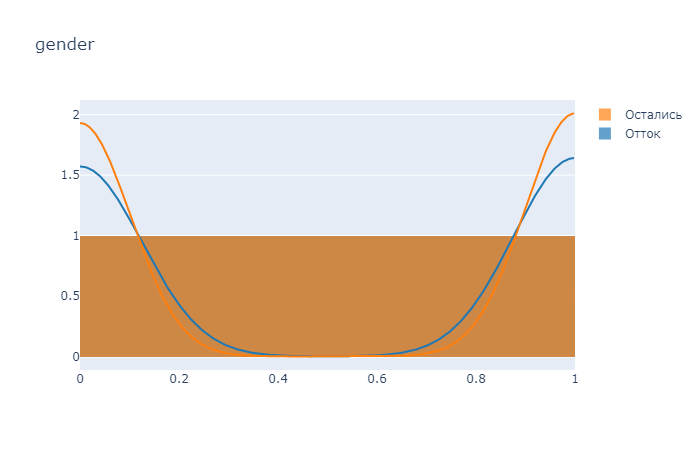

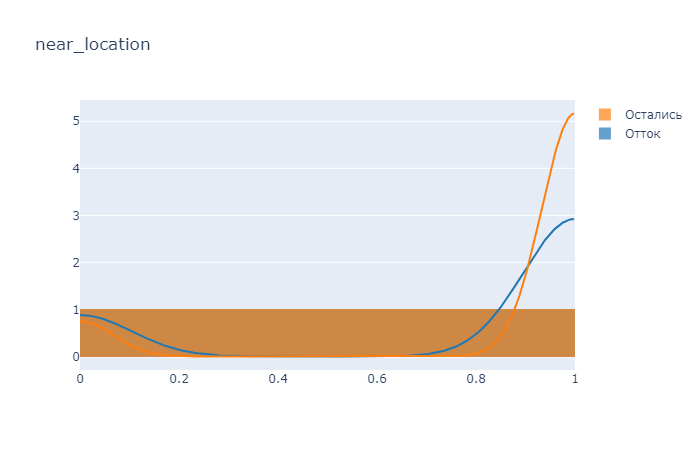

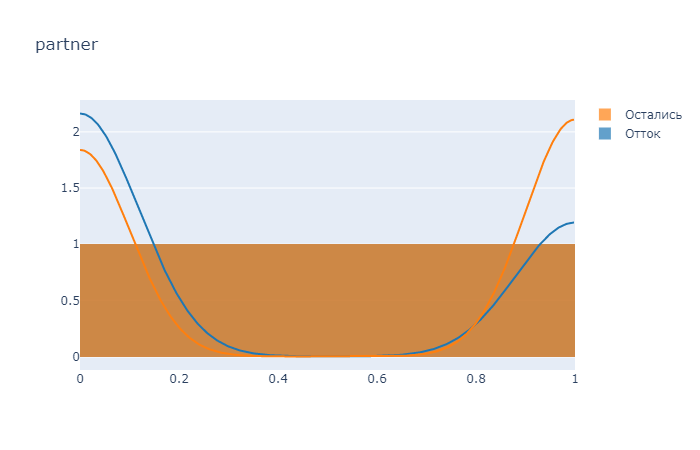

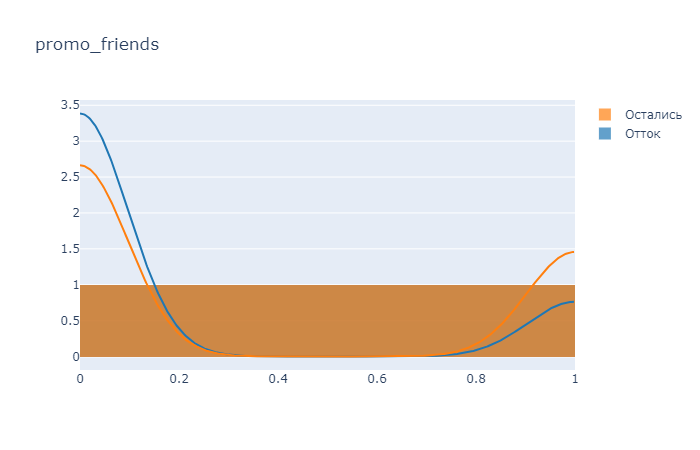

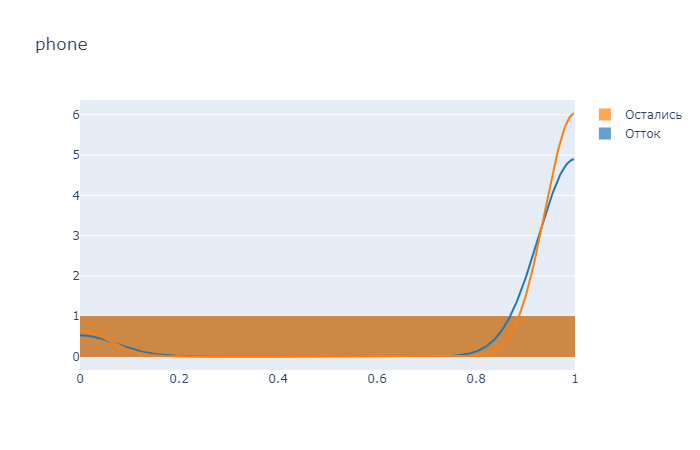

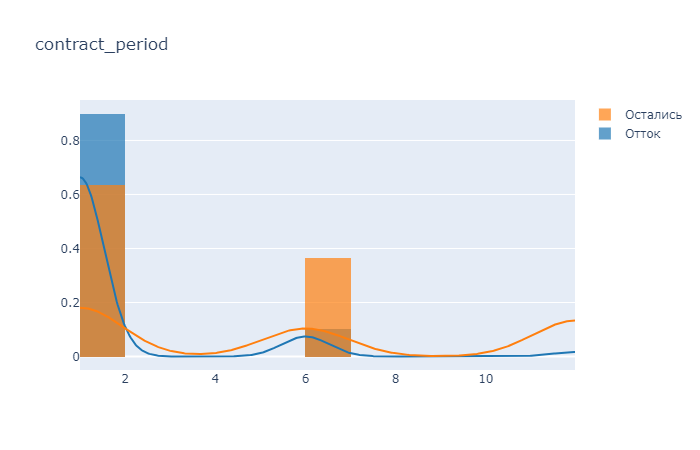

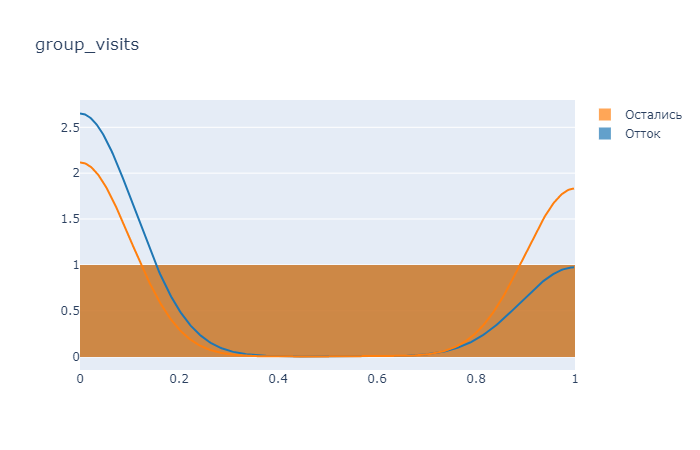

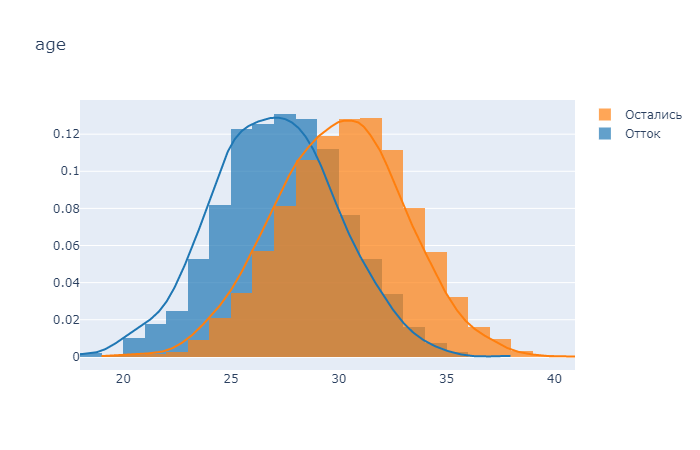

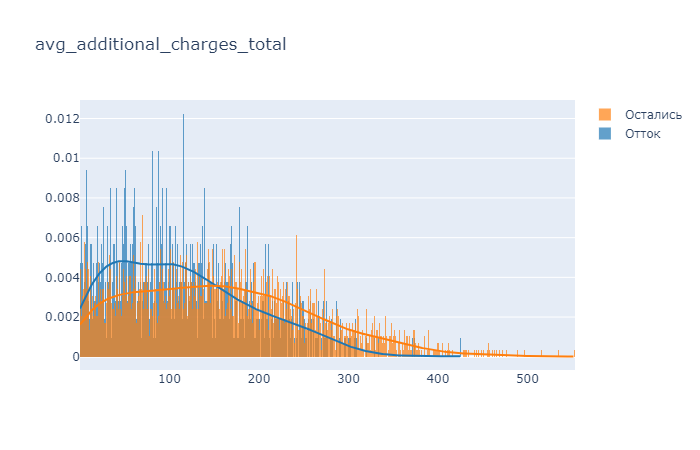

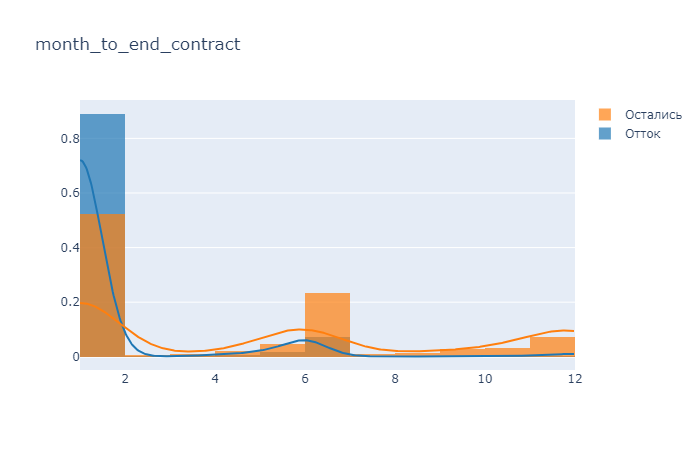

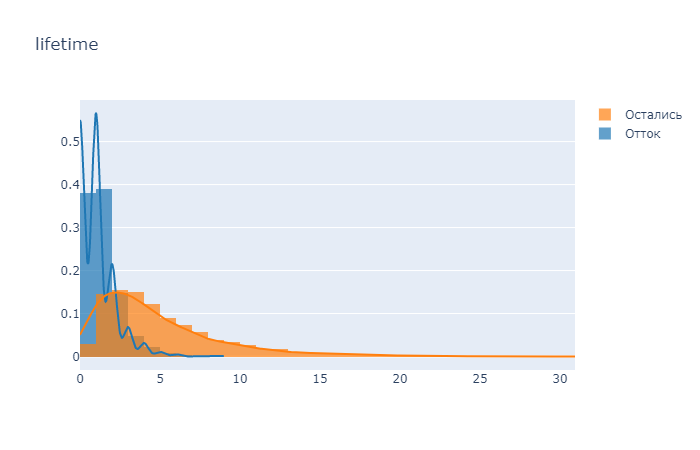

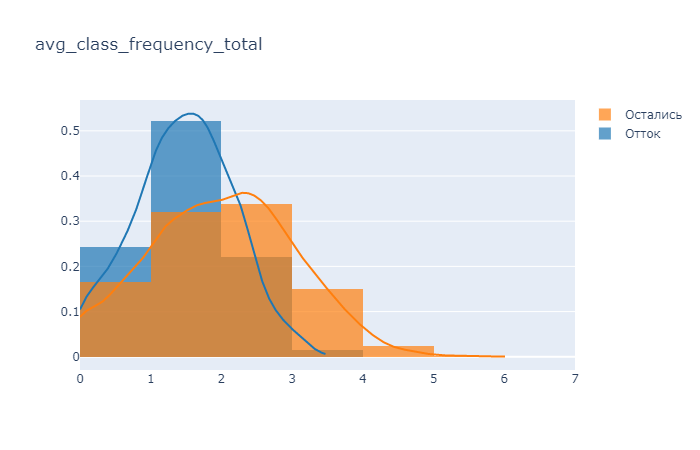

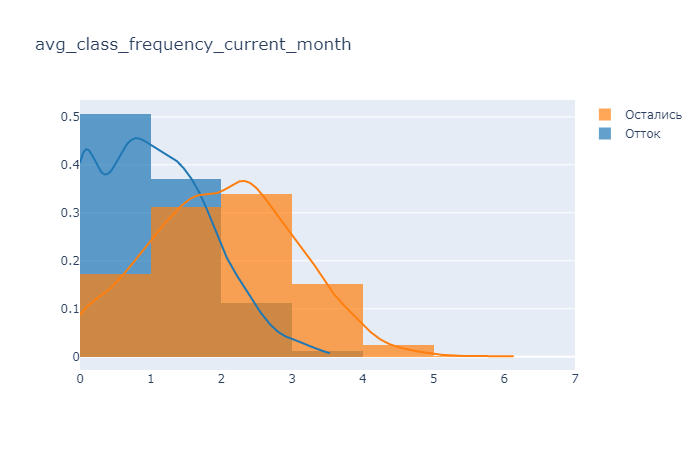

In [12]:
for column in df.drop('churn', axis = 1).columns:
    churn = df.query('churn == 1')
    no_churn = df.query('churn == 0')
    group_labels = ['Отток', 'Остались']
    data = [churn[column], no_churn[column]]
    fig = ff.create_distplot(data, group_labels, show_rug = False, bin_size = 1)
    fig.layout.update({'title': column})
    fig.show("png")

В целом выводы по распределениям совпадают с предыдущими, но стоит отметить пару моментов:
- Среди тех, кто ушел, было больше людей, которые жили рядом. Логично, ведь если ты уж поехал в зал подальше, то значит настроен серьезно
- Многие из тех, кто ушли, оформляли абонемент лишь на 1 месяц. А лояльные клиенты одинаково покупают абонементы разной длительности
- Почему-то ушедшие клиенты моложе оставшихся. Может у них не такой стабильный доход?
- Если клиент купил свой первый абонемент больше 2, а то и 3 месяцев назад, то скорее всего он останется с вами

- **Построим матрицу корреляций**

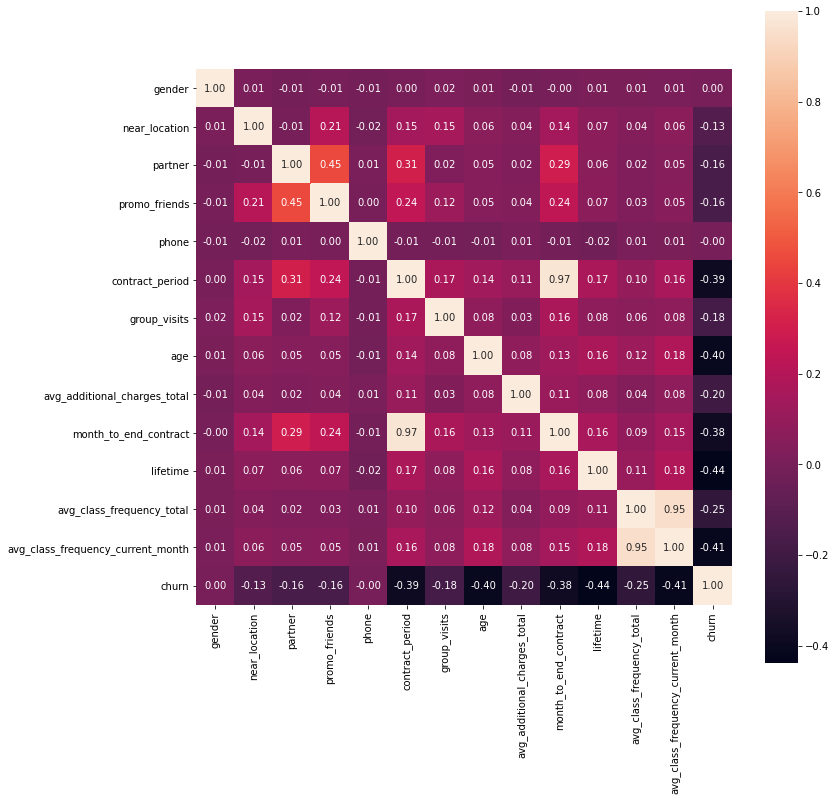

In [13]:
fig, ax = plt.subplots(figsize = (12, 12))
sns.heatmap(df.corr(), annot = True, square = True, fmt='.2f', cmap = 'rocket')
plt.show()

Видно, что почти все признаки имеют с величиной `churn` отрицательную корреляцию. Например, коэффициенты корреляции оттока с некоторыми величинами (с возрастом, с длительностью абонемента, с оставшимся число месяцев абонемента, с длительностью посещения зала в целом, с частотой посещений за последний месяц) равны примерно -0.4. Это скорее слабая корреляция, но стоит обратить внимание именно на эти столбцы.

Также стоит отметить величины, которые имеют между собой высокую корреляцию, так как они могут помещать обучению модели: 
- среднее число посещений за предыдущий месяц и за все время
- остаток месяцев до конца абонемента и срок абонемента

Оставим в каждой паре лишь одну величину: число посещений за последний месяц и срок абонемента

__Вывод шага 3:__

Данные проанализированы:
- отсутствующих признаков не обнаружено
- выяснено, что ушедшие клиенты минимально взаимодействуют с фитнес-залом (покупают самые короткие абонименты, не ходят на групповые занятия, редко ходят на обычные занятия, меньше тратят на доп услуги, не работают в компаниях-партнёрах)
- составлена матрица корреляций и определены величины сильнее всего (но все равно слабо) коррелирующие с оттоком:
    - возраст
    - длительность абонемента (купленного и оставшегося)
    - частота посещений за месяц (в целом и за последний месяц)
- определены признаки, сильно коррелирующие между собой (среднее число посещений за этот месяц/за все время; остаток месяцев до конца абонемента/срок абонемента). В каждой паре стоит один признак исключить из данных при построении модели, чтобы избежать переобучения

### Шаг 4. Модель прогнозирования оттока клиентов 

- **Разобьём данные на обучающую и валидационную выборку**

In [14]:
x = df.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis = 1)
y = df['churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

- **Обучим модель на train-выборке логистической регрессией**

In [15]:
model_regr = LogisticRegression(random_state = 0)
model_regr.fit(x_train, y_train)
y_pred_regr = model_regr.predict(x_test)

- **Обучим модель на train-выборке случайным лесом.**

In [16]:
model_forest = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_forest.fit(x_train, y_train)
y_pred_forest = model_forest.predict(x_test) 

- **Оценим метрики *accuracy, precision* и *recall* и сравним по ним модели**

In [17]:
def metrics(y_pred):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

In [18]:
print("Модель логистической регрессии")
metrics(y_pred_regr)
print()
print("Модель случайного леса")
metrics(y_pred_forest)

Модель логистической регрессии
Accuracy: 0.89
Precision: 0.78
Recall: 0.78

Модель случайного леса
Accuracy: 0.90
Precision: 0.81
Recall: 0.75


Для этой бизнес-задачи нам скорее важна полнота: нужно найти и удержать как можно больше пользователей, которые собираются уйти. А на постоянных клиентов стратегия удержания вряд ли повлияет негативно.

У логистической регрессии полнота больше, но все еще низкая - 79%. Попробуем увеличить полноту, снизив порог.

In [19]:
probs = model_regr.predict_proba(x_test)[:, 1]
threshold = 0.32 #порог
new_pred_regr = [0 if i < threshold else 1 for i in probs]

In [20]:
print("Модель логистической регрессии с порогом 0.32")
metrics(new_pred_regr)

Модель логистической регрессии с порогом 0.32
Accuracy: 0.88
Precision: 0.70
Recall: 0.89


Снизили порог до 0.32 и получили полноту в 90%. Теперь мы находим 90% уходящих клиентов, но немного потеряли в точности и в доле правильных ответов.

__Вывод шага 4:__

- Доля правильных ответов для обеих моделей 90%
- А вот точность и полнота отличаются:
    - у логистической регрессии больше полнота (*recall*)
    - у случайного леса выше точность (*precision*)
- Так как важнее не пропустить уходящего клиента, то стоит работать с моделью логистической регресии
- Выставляя порог 0.33 для этой модели, получим 90% полноты

### Шаг 5. Кластеризация клиентов

- **Стандартизируем данные**

In [21]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(x)

- **Построим матрицу расстояний и нарисуем дендрограмму. Предположим, какое количество кластеров можно выделить**

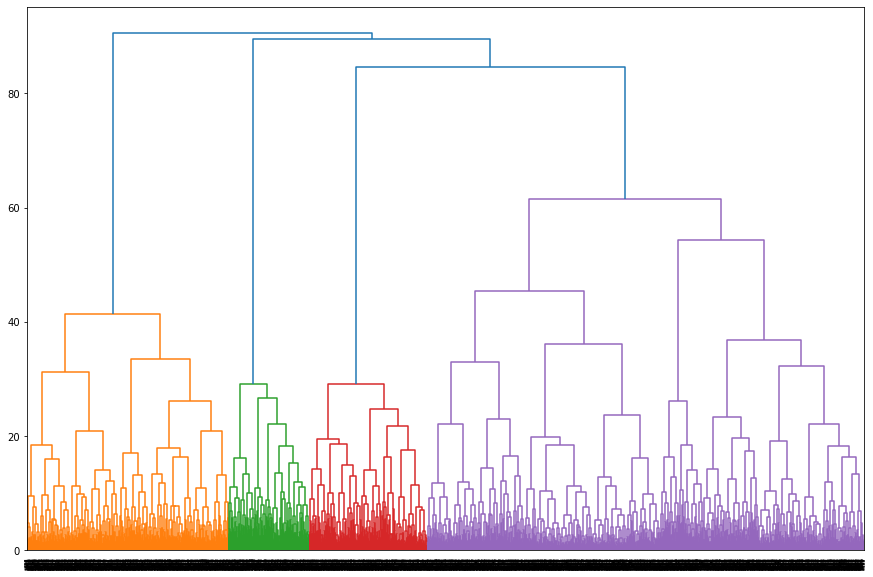

In [22]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize = (15, 10))  
dendrogram(linked, orientation = 'top')
plt.show() 

Самый простой способ разделить на кластеры: по цветам. Получается 4 кластера.

- **Обучим модель кластеризации и спрогнозируем кластеры клиентов**

Но четвертый кластер достаточно большой, можно взять 5 за число кластеров.

In [23]:
km = KMeans(n_clusters = 5, random_state = 0) 
#формируем вектор кластеров
labels = km.fit_predict(x_sc)
df['cluster'] = labels
df['cluster'] = df['cluster'] + 1

- **Посмотрим на средние значения признаков для кластеров**

In [24]:
df.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis = 1).groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
cluster,,,,,,,,,,,
1,0.490654,1.000000,0.217757,0.070093,1.0,2.047664,0.289720,27.673832,117.271746,1.935514,1.182898
2,0.495943,0.995943,0.891481,1.000000,1.0,6.911765,0.523327,29.601420,153.355426,4.281947,1.919083
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967
4,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146
5,0.546000,0.996000,0.380000,0.011000,1.0,6.204000,0.528000,30.627000,178.905160,5.425000,2.353631


Уже по средним значениям можно предположить, какие кластеры скорее надёжные, а в каких больше шанс оттока.

К надёжным я бы отнесла 2 и 5 кластеры, так как клиенты из них:
   - в среднем имеют абонементы на больший срок (от 6 месяцев)
   - часто посещают групповые занятия (больше 50% людей из этих кластеров)
   - они больше тратят на доп. услуги (от 150 у.е.)
   - они уже больше 4 месяцев являются клиентами
   - и часто посещают занятия (около 2 раз в неделю)
   
   
А к "отточным" кластерам можно отнести 1, так как эти клиенты:
   - покупают короткие абонементы (скорее на 1 месяц)
   - редко посещают групповые занятия (лишь 28% людей ходят на них)
   - тратят меньше на другие услуги
   - явлются самыми новыми клиентами
   - и в последний месяц ходят на занятия лишь 1 раз в неделю
   
   
3 и 4 кластеры нельзя уверенно отнести ни к одной из групп, нужно проводить исследование дальше.

- **Построим распределения признаков для кластеров**

In [25]:
cluster1 = df.query('cluster == 1')
cluster2 = df.query('cluster == 2')
cluster3 = df.query('cluster == 3')
cluster4 = df.query('cluster == 4')
cluster5 = df.query('cluster == 5')

Посмотрим на распределения не бинарных признаков (возраста, среднего числа посещений за месяц и т.д.)

In [26]:
non_bin_cols = []
for column in df.drop('cluster', axis = 1).columns:
    if (df[column].max() != 1) & (df[column].min != 0):
        non_bin_cols.append(column)

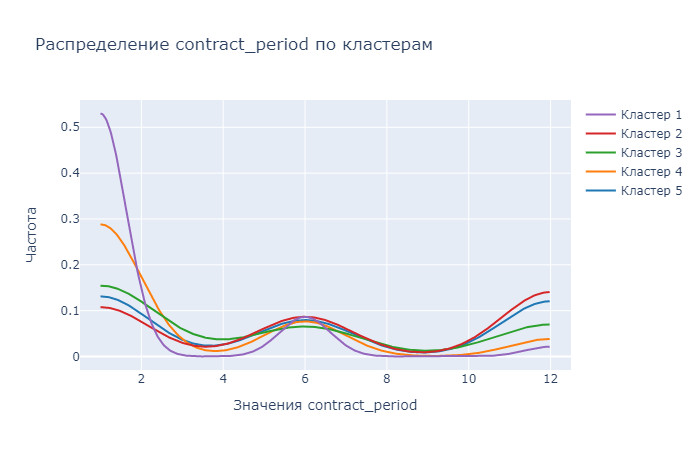

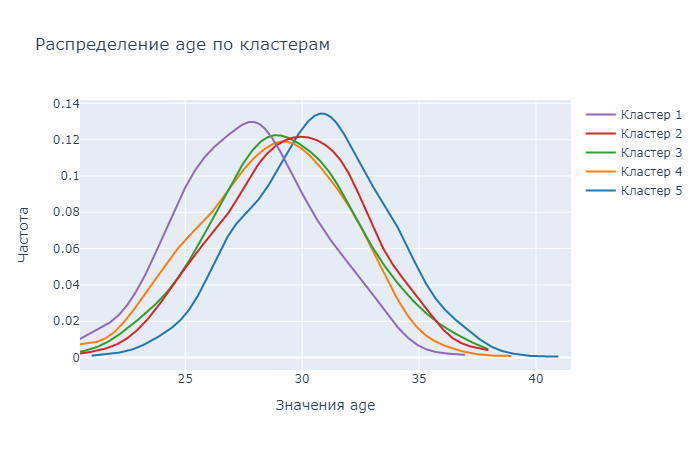

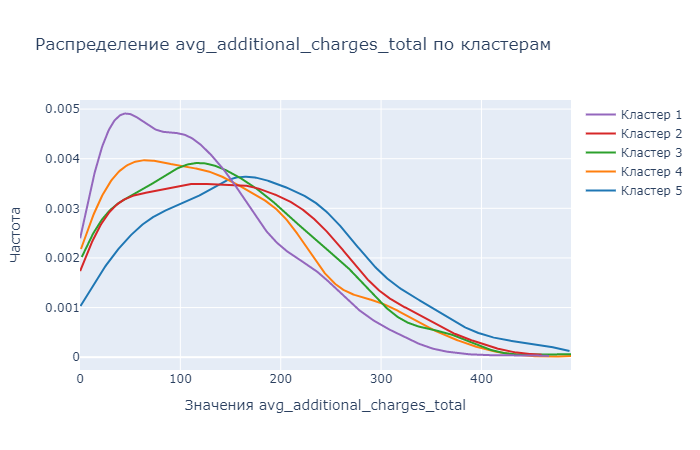

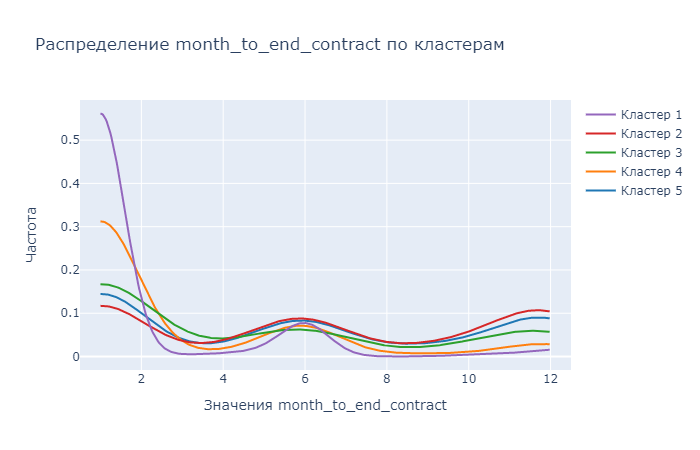

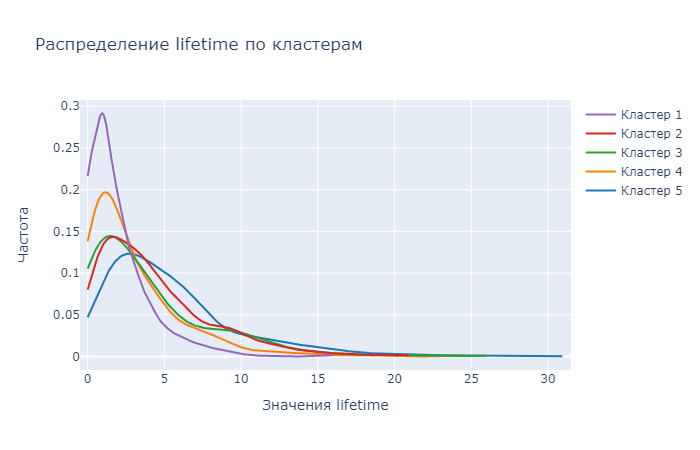

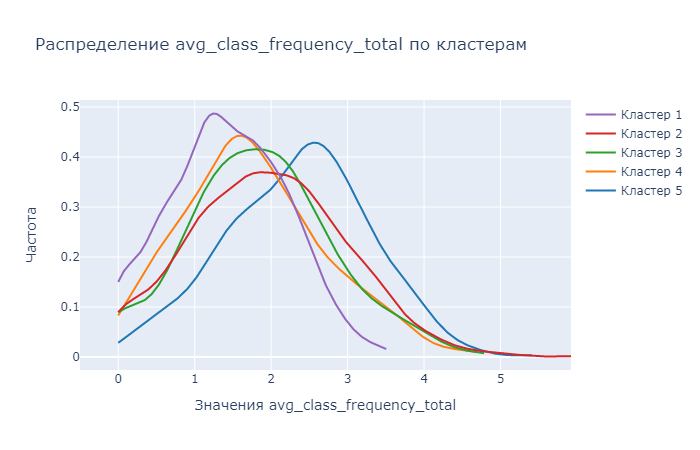

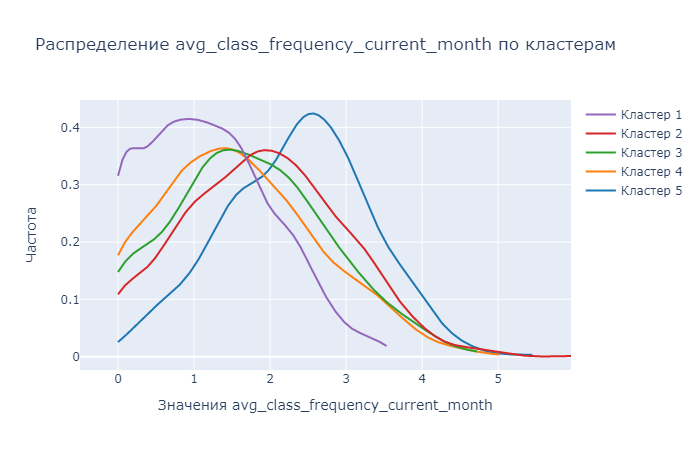

In [27]:
for column in non_bin_cols:
    group_labels = ['Кластер 5', 'Кластер 4', 'Кластер 3', 'Кластер 2', 'Кластер 1']
    data = [cluster5[column], cluster4[column], 
            cluster3[column], cluster2[column], cluster1[column]]
    fig = ff.create_distplot(data, group_labels, 
                             show_hist = False, show_rug = False, bin_size = 1)
    fig.update_layout(xaxis = dict(range = [cluster5[column].min() - 0.5, 
                                            cluster5[column].max() + 0.5]))
    fig.layout.update({'title': 'Распределение ' + column + ' по кластерам'})
    fig.update_xaxes(title_text = 'Значения ' + column)
    fig.update_yaxes(title_text = 'Частота')
    fig.show("png")

В целом распределения по кластерам подтверждают предыдущие выводы:
- 1 кластер показывает худшие результаты относительно других
- 2 и 5 кластеры наоборот показывают лучшие значения
- а из оставшихся кластеров 4 больше похож на отточный, а 3 имеет средние значения

- **Посчитаем долю оттока для кластеров и найдем надёжные и склонные к оттоку кластеры**

In [28]:
df.groupby('cluster').agg({'churn': ['mean', 'median']})

churn       
             mean median
cluster                 
1        0.558879      1
2        0.119675      0
3        0.266839      0
4        0.403226      0
5        0.017000      0

Как и ожидалось, клиенты из 1 кластера почти в 60% случаях уходят.
На втором месте по уходам 4 кластер с 40% вероятностью.

А надёжными действительно оказались 2 и 5 кластеры (5 самый надёжный). 

В 3 кластере четверь клиентов уходит в отток, надо обращать внимание и на него.

__Вывод шага 5:__



Данные стандартизированы и разбиты на 5 кластеров.

По средним значениям, графикам распределения и доле оттока определили, что надёжными являются 2 и 5 кластеры с лояльными клиентами, которые часто и давно ходят, много тратят и покупают абонементы на большой срок.

А вот на ненадёжных клиентов из 1, 3 и 4 кластеров стоит обратить внимание, они очень склонны к оттоку (от 25% до 60% людей уходят в отток).

### Шаг 6. Общий вывод 

1. Были проанализированы данные фитнес-центра на месяц до оттока и факт оттока на определённый месяц
1. Произведена предобработка данных (изменены названия столбцов, оптимизирована память). Данные в целом оказались "чистыми"
1. Проведён исследовательский анализ данных и определено, что сильнее всего на отток влияют следующие факторы:
    - длительность купленного абонемента (чем меньше срок, тем больше шанс уйти)
    - возраст клиента (уходят более молодые)
    - частота посещений в неделю за последний месяц (кто ходит меньше 1 раза в неделю, должны попасть под подозрение)
1. Построены 2 модели (случайный лес и логистическая регрессия) прогнозирования оттока клиентов, для каждой из них посчитаны основные метрики. На основании метрики recall (полнота) выбрана модель логистической регрессии с порогом 0.32 (для нахождения 90% уходящих клиентов) 
1. Произведена кластеризация клиентов. Количество кластеров считали за 5. На основе средних значений, распределений и доле оттока были найдены надёжные кластеры - 5 и 2 (по мере возрастания доли оттока) и "отточные" кластеры - 1, 4 и 3 (по мере убывания доли оттока)

**Рекомендации:** 
1. Потенциально уходящие клиенты имеют абонемент на короткий срок (1 месяц). Стоит стимулировать покупать абонементы на 6 и на 12 месяцев, например, делая на них скидки и показывая их выгоду.
1. Лояльные клиенты чаще ходят на групповые тренировки (возможно, на групповых занятиях можно найти приятную компанию, из-за которой не захочется бросать фитнес). Таким образом, нужно поощрять клиентов заниматься в группе, опять же с помощью системы скидок.
1. Чаще уходят новые клиенты (которые занимаются 1-2 месяца). Поэтому стоит развивать стратегию, направленную на удержание именно новичков. 